#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
import math
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Activation
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Datasets

In [ ]:
def load_dataframe(subset_number):
    turbo_train= pd.read_csv(f"/content/drive/MyDrive/NASAturbofan/train_FD00{subset_number}.txt", sep='\s+',header=None, index_col=False)
    turbo_test = pd.read_csv(f'/content/drive/MyDrive/NASAturbofan/test_FD00{subset_number}.txt', sep='\s+',header=None, index_col=False)
    y_RUL = pd.read_csv(f'/content/drive/MyDrive/NASAturbofan/RUL_FD00{subset_number}.txt', sep='\s+',header=None, index_col=False)
    return turbo_train, turbo_test, y_RUL


In [ ]:
turbo_train_1, turbo_test_1, y_RUL_1 = load_dataframe(1)
turbo_train_2, turbo_test_2, y_RUL_2 = load_dataframe(2)
turbo_train_3, turbo_test_3, y_RUL_3 = load_dataframe(3)
turbo_train_4, turbo_test_4, y_RUL_4 = load_dataframe(4)

In [ ]:
def count_engines(turbofan):
  unique_engines = turbofan[0].unique()
  num_engines = len(unique_engines)
  return num_engines

In [ ]:
nr_train_1=count_engines(turbo_train_1)
nr_train_2=count_engines(turbo_train_2)
nr_train_3=count_engines(turbo_train_3)
nr_train_4=count_engines(turbo_train_4)
nr_test_1=count_engines(turbo_test_1)
nr_test_2=count_engines(turbo_test_2)
nr_test_3=count_engines(turbo_test_3)
nr_test_4=count_engines(turbo_test_4)

In [ ]:
nr_test_2

259

In [ ]:
def original_RUL_train(turbo_train):
  turbo_train.sort_values(by=[0, 1], inplace=True)
  turbo_train['RUL'] = turbo_train.groupby(0).cumcount(ascending=False)
  return turbo_train

In [ ]:
turbo_train_1=original_RUL_train(turbo_train_1)
turbo_train_2=original_RUL_train(turbo_train_2)
turbo_train_3=original_RUL_train(turbo_train_3)
turbo_train_4=original_RUL_train(turbo_train_4)

In [ ]:
turbo_train_4

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,4
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,3
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,2
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,1


In [ ]:
def original_RUL_test(turbo_test, y_RUL):
  y_RUL_series=y_RUL[0]
  turbo_test.sort_values(by=[0, 1], inplace=True)
  adjusted_engine_numbers = turbo_test[0].values - 1
  turbo_test['RUL'] = turbo_test.groupby(0).cumcount(ascending=False) + y_RUL_series.iloc[adjusted_engine_numbers].values
  return turbo_test

In [ ]:
turbo_test_1=original_RUL_test(turbo_test_1, y_RUL_1)
turbo_test_2=original_RUL_test(turbo_test_2, y_RUL_2)
turbo_test_3=original_RUL_test(turbo_test_3, y_RUL_3)
turbo_test_4=original_RUL_test(turbo_test_4, y_RUL_4)

In [ ]:
turbo_test_4

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41209,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,2388.50,8112.61,9.4427,0.02,331,2212,100.00,10.53,6.2620,30
41210,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,2388.33,8086.83,9.2772,0.02,366,2324,100.00,24.33,14.6486,29
41211,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,2388.64,8100.84,9.3982,0.02,336,2223,100.00,14.69,8.8389,28
41212,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,2388.37,8085.24,9.2727,0.03,366,2324,100.00,24.44,14.6887,27


In [ ]:
def complete_dataframe(turbo_train, turbo_test):
  turbo_test_reset = turbo_test.reset_index(drop=True)
  last_engine = turbo_train[0].iloc[-1]
  turbo_test_reset[0] += last_engine
  turbofan = pd.concat([turbo_train, turbo_test_reset], ignore_index=True)
  return turbofan

In [ ]:
turbofan1=complete_dataframe(turbo_train_1, turbo_test_1)
turbofan2=complete_dataframe(turbo_train_2, turbo_test_2)
turbofan3=complete_dataframe(turbo_train_3, turbo_test_3)
turbofan4=complete_dataframe(turbo_train_4, turbo_test_4)

In [ ]:
turbofan1

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [ ]:
def rename_columns(turbofan):
  new_columns = ['ENr', 'C', 'OP-1', 'OP-2', 'OP-3',
                 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'Epr', 'Ps30', 'Phi',
                 'NRf', 'Nrc', 'BPR', 'farB', 'htBleed', 'NF-dmd', 'PCNR-dmd', 'W31', 'W32', 'RUL']
  turbofan.columns = new_columns
  return turbofan

In [ ]:
turbofan1=rename_columns(turbofan1)
turbofan2=rename_columns(turbofan2)
turbofan3=rename_columns(turbofan3)
turbofan4=rename_columns(turbofan4)

In [ ]:
turbofan1

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
33723,200,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
33724,200,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
33725,200,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


#Exploratory Data Analysis

##Univariate

In [ ]:
def get_info(turbofan):
   return turbofan.info()

In [ ]:
info1=get_info(turbofan1)
info2=get_info(turbofan2)
info3=get_info(turbofan3)
info4=get_info(turbofan4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33727 entries, 0 to 33726
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ENr       33727 non-null  int64  
 1   C         33727 non-null  int64  
 2   OP-1      33727 non-null  float64
 3   OP-2      33727 non-null  float64
 4   OP-3      33727 non-null  float64
 5   T2        33727 non-null  float64
 6   T24       33727 non-null  float64
 7   T30       33727 non-null  float64
 8   T50       33727 non-null  float64
 9   P2        33727 non-null  float64
 10  P15       33727 non-null  float64
 11  P30       33727 non-null  float64
 12  Nf        33727 non-null  float64
 13  Nc        33727 non-null  float64
 14  Epr       33727 non-null  float64
 15  Ps30      33727 non-null  float64
 16  Phi       33727 non-null  float64
 17  NRf       33727 non-null  float64
 18  Nrc       33727 non-null  float64
 19  BPR       33727 non-null  float64
 20  farB      33727 non-null  fl

In [ ]:
def check_missing(turbofan):
   return turbofan.isnull().sum()

In [ ]:
missing1=check_missing(turbofan1)
missing2=check_missing(turbofan2)
missing3=check_missing(turbofan3)
missing4=check_missing(turbofan4)

In [ ]:
missing4

ENr         0
C           0
OP-1        0
OP-2        0
OP-3        0
T2          0
T24         0
T30         0
T50         0
P2          0
P15         0
P30         0
Nf          0
Nc          0
Epr         0
Ps30        0
Phi         0
NRf         0
Nrc         0
BPR         0
farB        0
htBleed     0
NF-dmd      0
PCNR-dmd    0
W31         0
W32         0
RUL         0
dtype: int64

In [ ]:
def unique_values(turbofan):
   return turbofan.nunique()

In [ ]:
unique1=unique_values(turbofan1)
unique2=unique_values(turbofan2)
unique3=unique_values(turbofan3)
unique4=unique_values(turbofan4)

In [ ]:
unique3

ENr          200
C            525
OP-1         163
OP-2          14
OP-3           1
T2             1
T24          344
T30         3521
T50         4548
P2             1
P15           17
P30         1882
Nf           167
Nc          7725
Epr            4
Ps30         175
Phi         1796
NRf          169
Nrc         6767
BPR         3152
farB           1
htBleed       13
NF-dmd         1
PCNR-dmd       1
W31          165
W32         6698
RUL          525
dtype: int64

NOTE: Here we can see the columns with constant columns and the attributes dependent on the number of conditions

In [ ]:
def statistics(turbofan):
  description=turbofan.describe()
  skewness = turbofan.apply(skew)
  kurt = turbofan.apply(kurtosis)
  statistics = turbofan.describe()
  statistics.loc['skewness'] = skewness
  statistics.loc['kurtosis'] = kurt
  return statistics

In [ ]:
stat1=statistics(turbofan1)
stat2=statistics(turbofan2)
stat3=statistics(turbofan3)
stat4=statistics(turbofan4)

In [ ]:
stat4

,ENr,C,OP-1,OP-2,OP-3,T2,T24,T30,T50,P2,...,NRf,Nrc,BPR,farB,htBleed,NF-dmd,PCNR-dmd,W31,W32,RUL
count,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,...,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000,102463.000000
mean,222.743888,124.025385,24.046234,0.572705,94.048193,472.813726,579.278956,1416.712022,1200.067378,8.020251,...,2334.550571,8065.959530,9.285226,0.023163,347.444795,2228.592009,97.757657,20.837898,12.503177,152.855187
std,139.858594,88.288695,14.754162,0.309970,14.235528,26.390489,37.257343,105.878109,118.898635,3.614543,...,128.048614,85.082502,0.747948,0.004650,27.729173,145.229217,5.363235,9.913949,5.949074,93.825416
min,1.000000,1.000000,0.000000,0.000000,60.000000,445.000000,535.420000,1240.940000,1024.420000,3.910000,...,2027.570000,7845.780000,8.175700,0.020000,302.000000,1915.000000,84.930000,10.160000,6.084300,0.000000
25%,105.000000,53.000000,10.004700,0.250700,100.000000,445.000000,549.280000,1349.630000,1118.215000,3.910000,...,2387.900000,8061.910000,8.642800,0.020000,330.000000,2212.000000,100.000000,10.920000,6.556200,81.000000
50%,207.000000,109.000000,25.001500,0.700000,100.000000,462.540000,555.650000,1366.530000,1134.410000,7.050000,...,2388.050000,8082.160000,9.257800,0.020000,334.000000,2223.000000,100.000000,14.930000,8.959500,144.000000
75%,337.000000,178.000000,41.998100,0.840000,100.000000,491.190000,607.000000,1496.340000,1301.105000,10.520000,...,2388.140000,8127.400000,9.360000,0.030000,368.000000,2324.000000,100.000000,28.570000,17.141100,210.000000
max,497.000000,543.000000,42.008000,0.842000,100.000000,518.670000,644.420000,1613.000000,1440.770000,14.620000,...,2390.490000,8261.650000,11.066300,0.030000,399.000000,2388.000000,100.000000,39.890000,23.885200,553.000000
skewness,0.252763,0.839890,-0.263635,-0.837642,-1.973690,0.460900,0.446200,0.171387,0.434660,0.540747,...,-1.973683,-1.431087,1.040210,0.790250,0.187423,-1.222332,-1.973690,0.646536,0.646602,0.669713
kurtosis,-1.060634,0.450028,-1.225285,-0.862945,1.895453,-1.176437,-1.305780,-1.129782,-1.100341,-0.845939,...,1.895443,0.935574,0.367035,-1.375504,-1.128358,0.501914,1.895453,-0.931173,-0.930748,0.353523


NOTE: The warning is generated when calculating skewness and kurtosis for the constant attributes (because division is made with 0)

In [ ]:
def boxplots(turbofan):
  for x in turbofan.columns:
      plt.figure(figsize=(7,5))
      plt.boxplot(turbofan1[x])
      plt.title(x)
      plt.show()

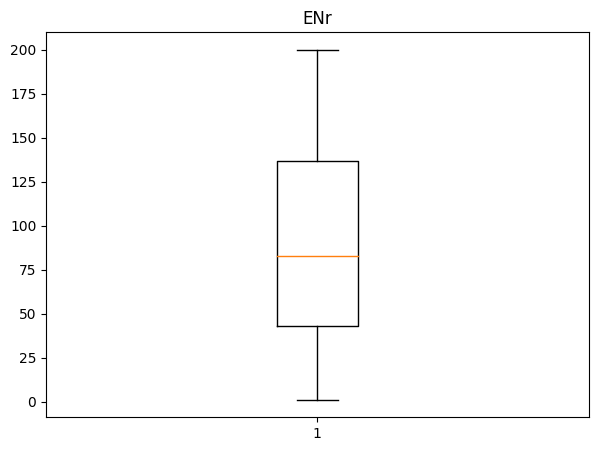

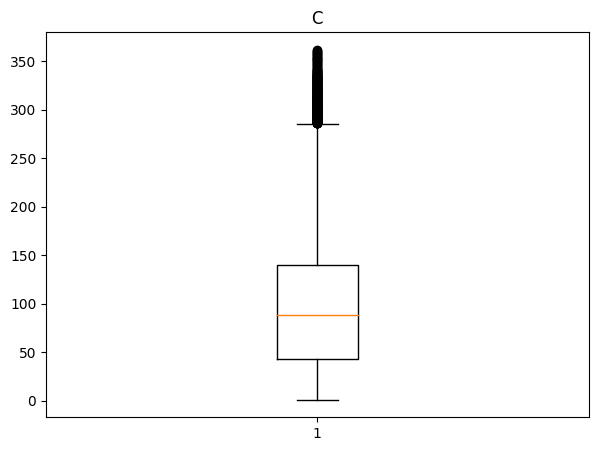

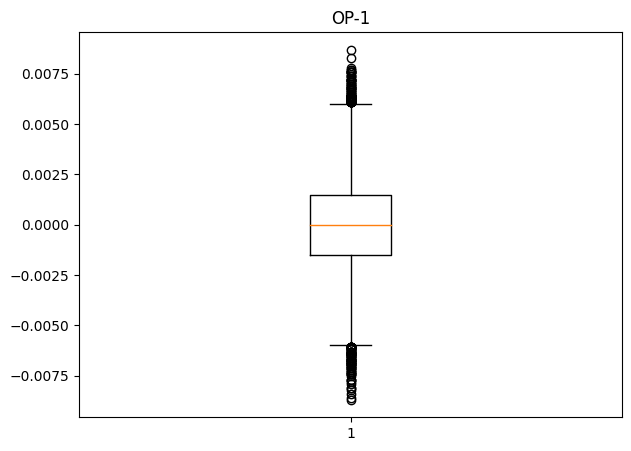

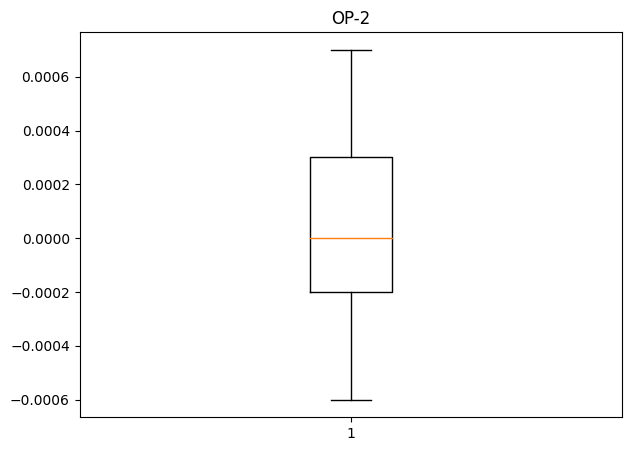

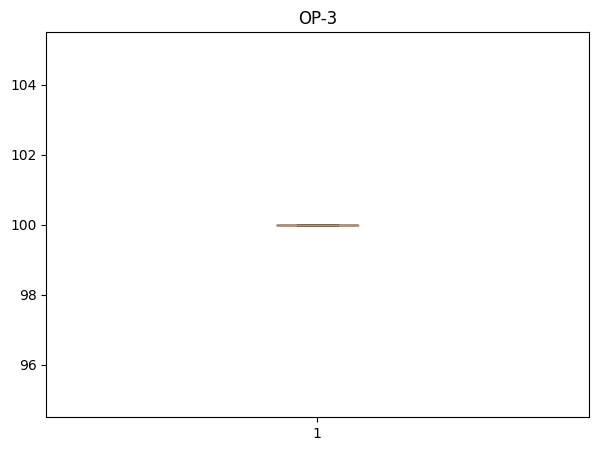

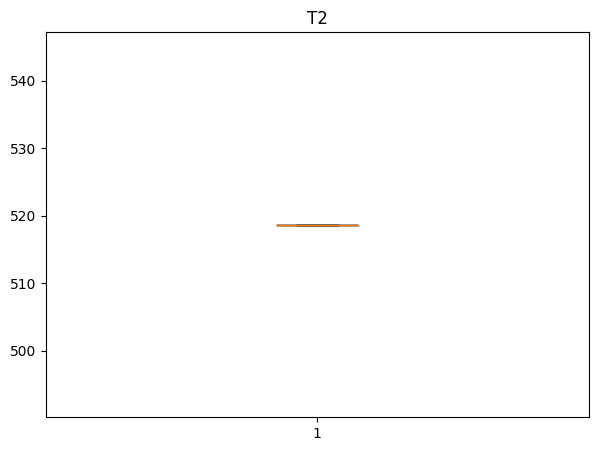

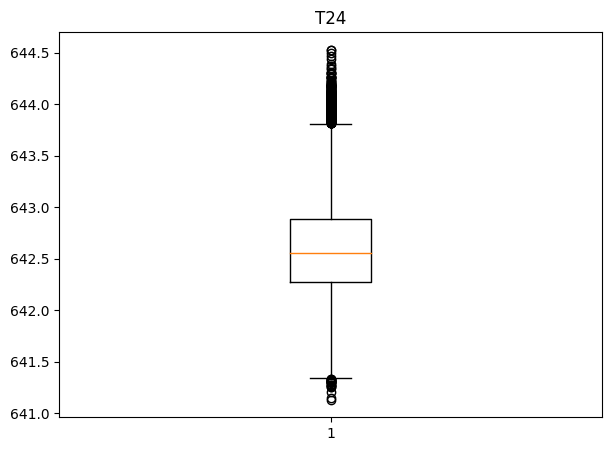

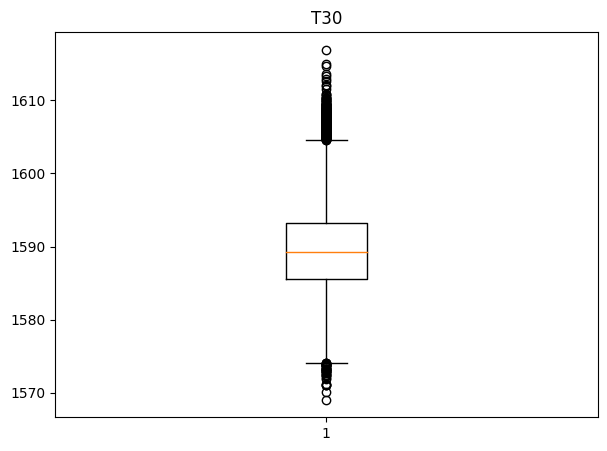

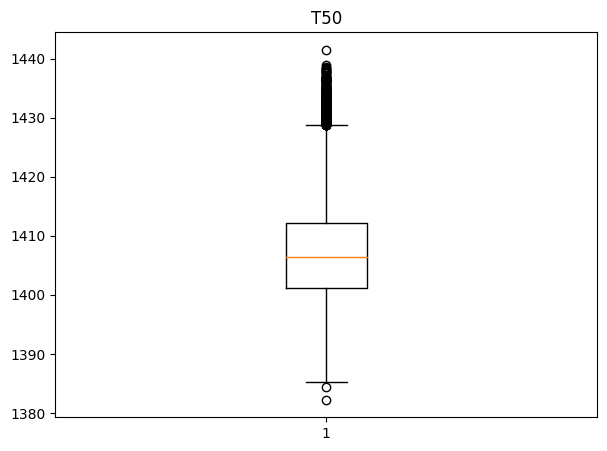

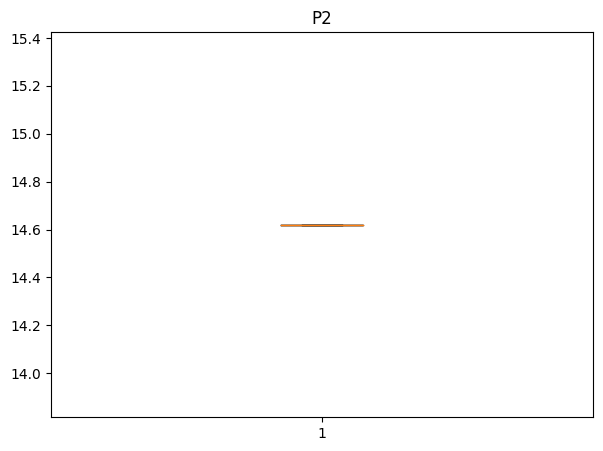

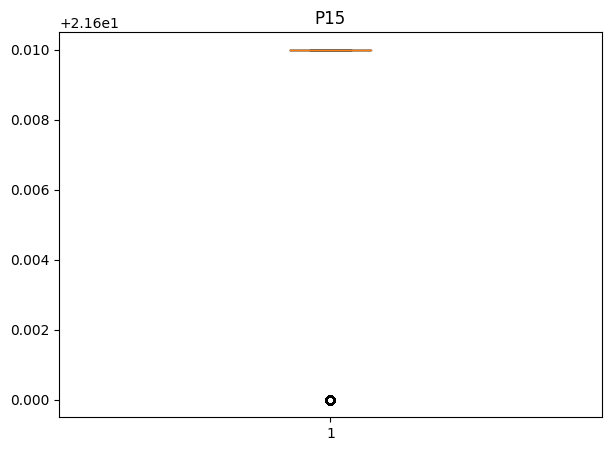

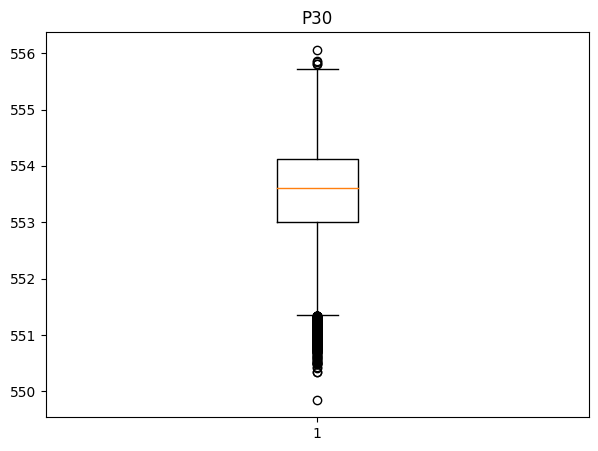

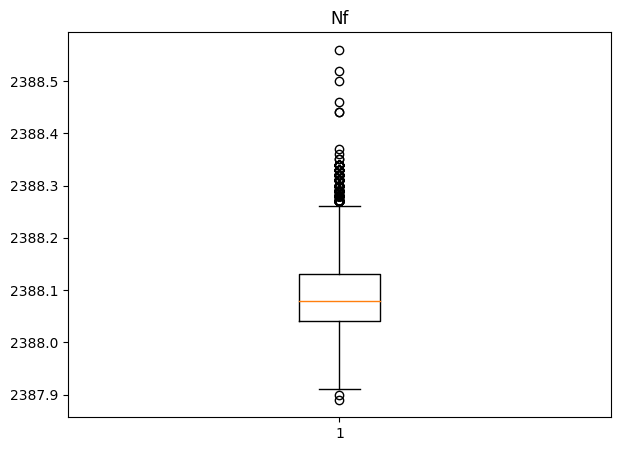

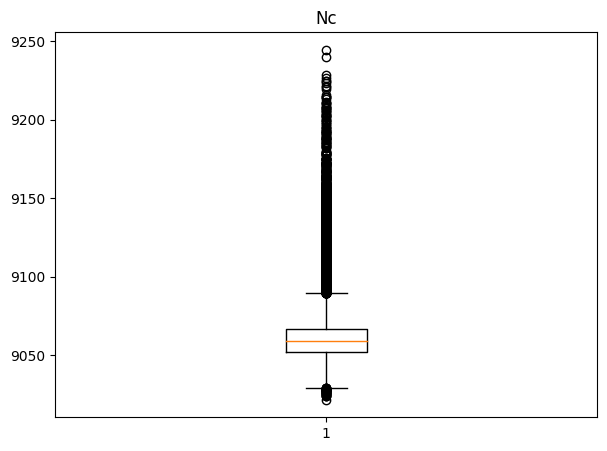

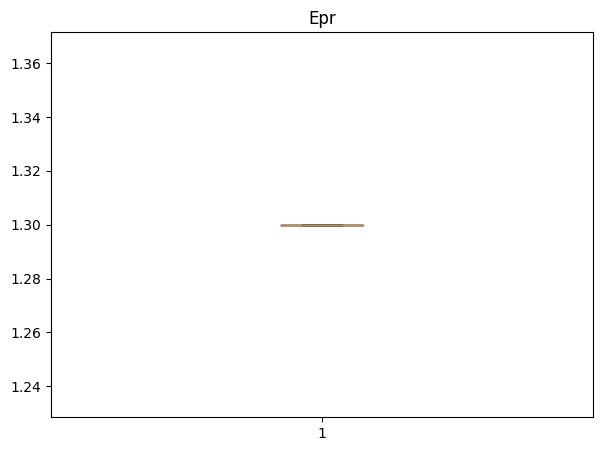

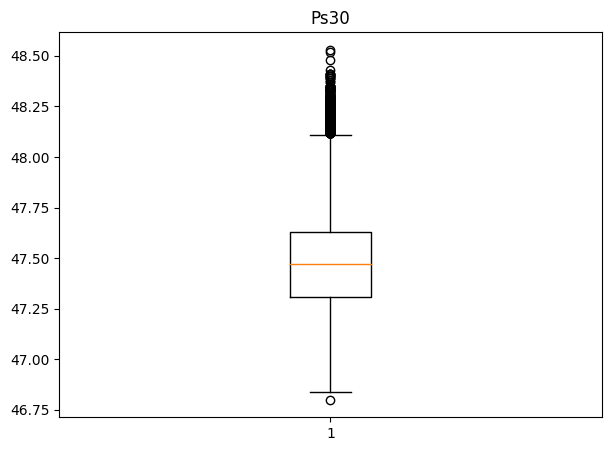

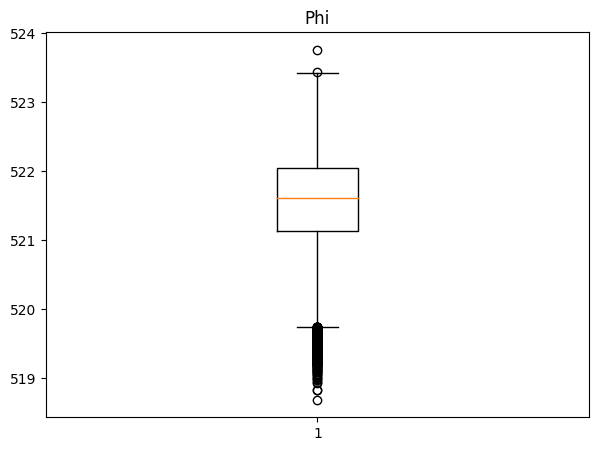

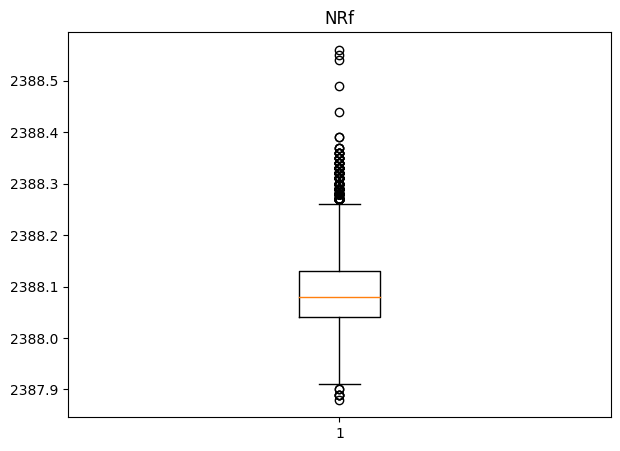

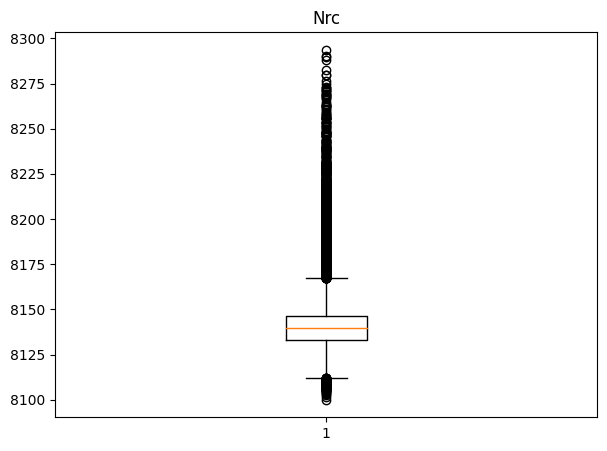

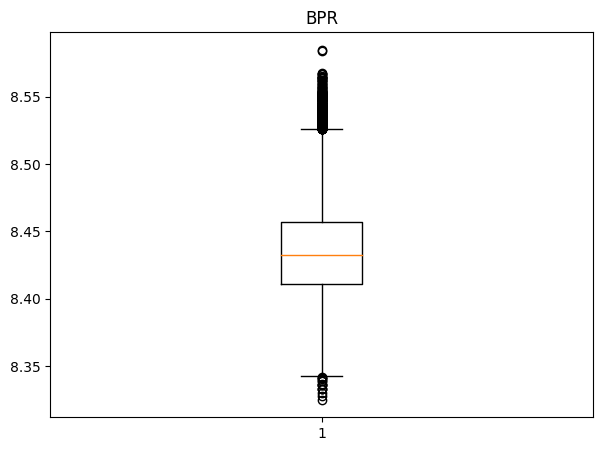

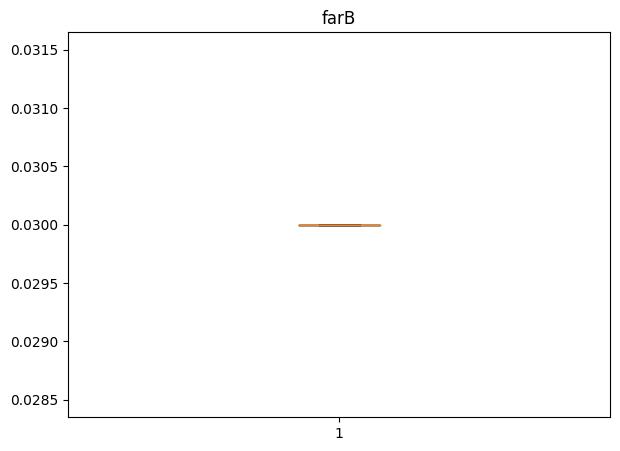

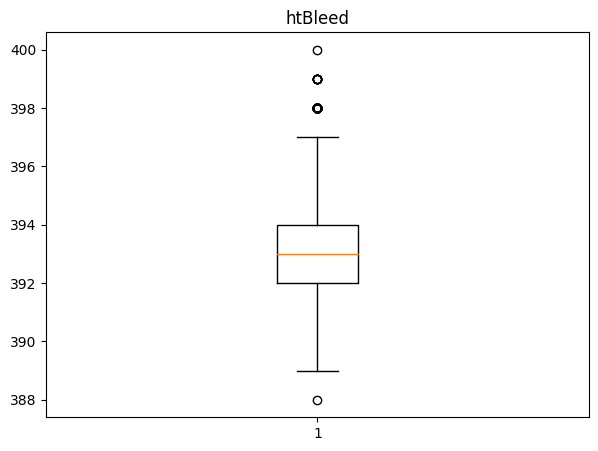

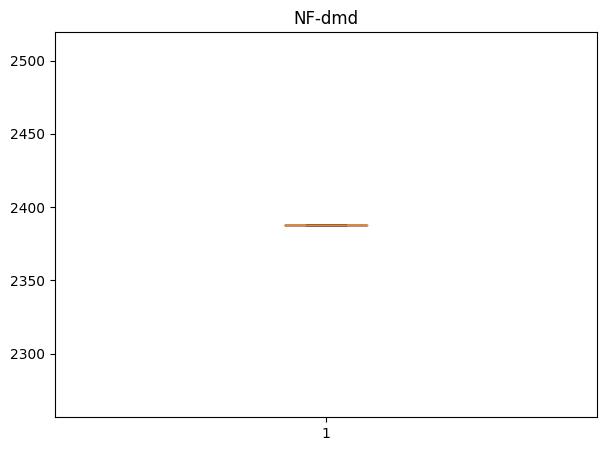

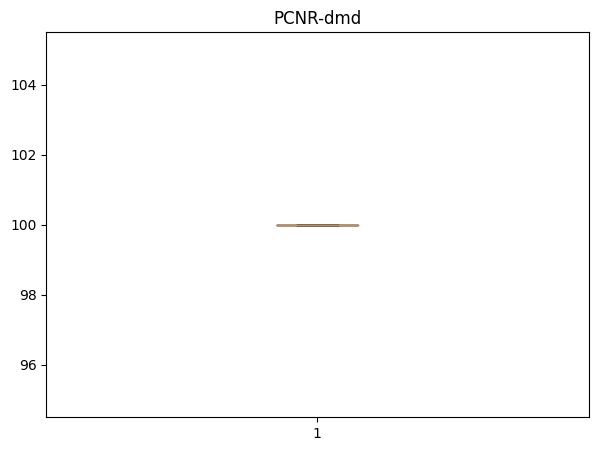

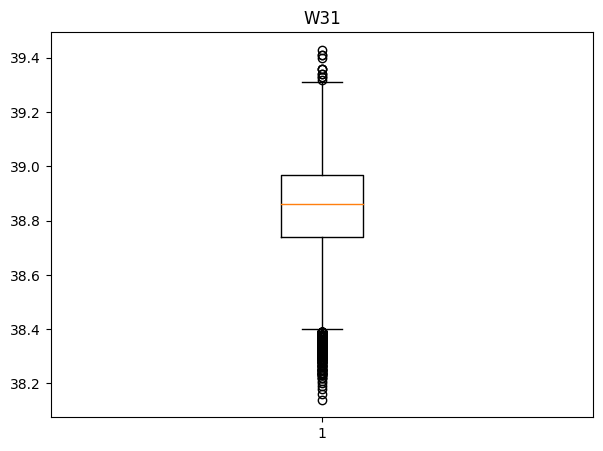

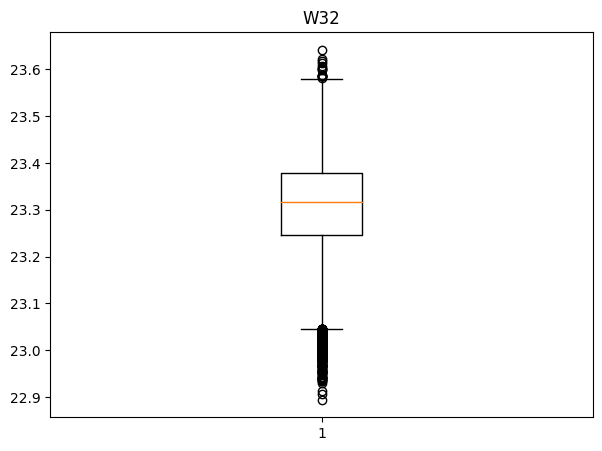

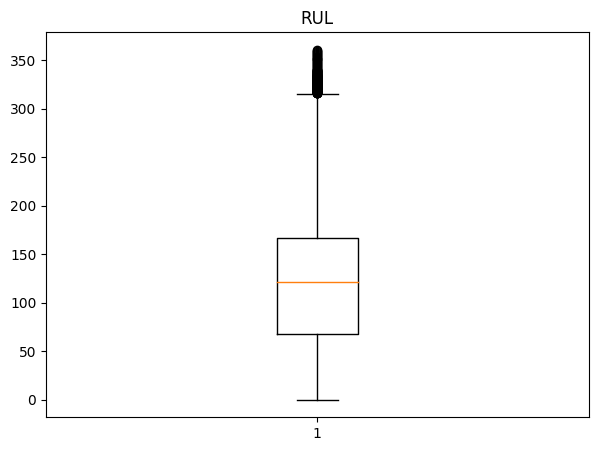

In [ ]:
boxplots(turbofan4)

BOXPLOT CONCLUSION: There are a lot of outliers

##Correlation Analysis

In [ ]:
def compute_pearson(turbofan):
  correlation_matrix = abs(turbofan.corr(method='pearson'))*100
  target_column = 'RUL'
  correlation = correlation_matrix[target_column]
  return round(correlation, 3)

In [ ]:
p1=compute_pearson(turbofan1)
p2=compute_pearson(turbofan2)
p3=compute_pearson(turbofan3)
p4=compute_pearson(turbofan4)

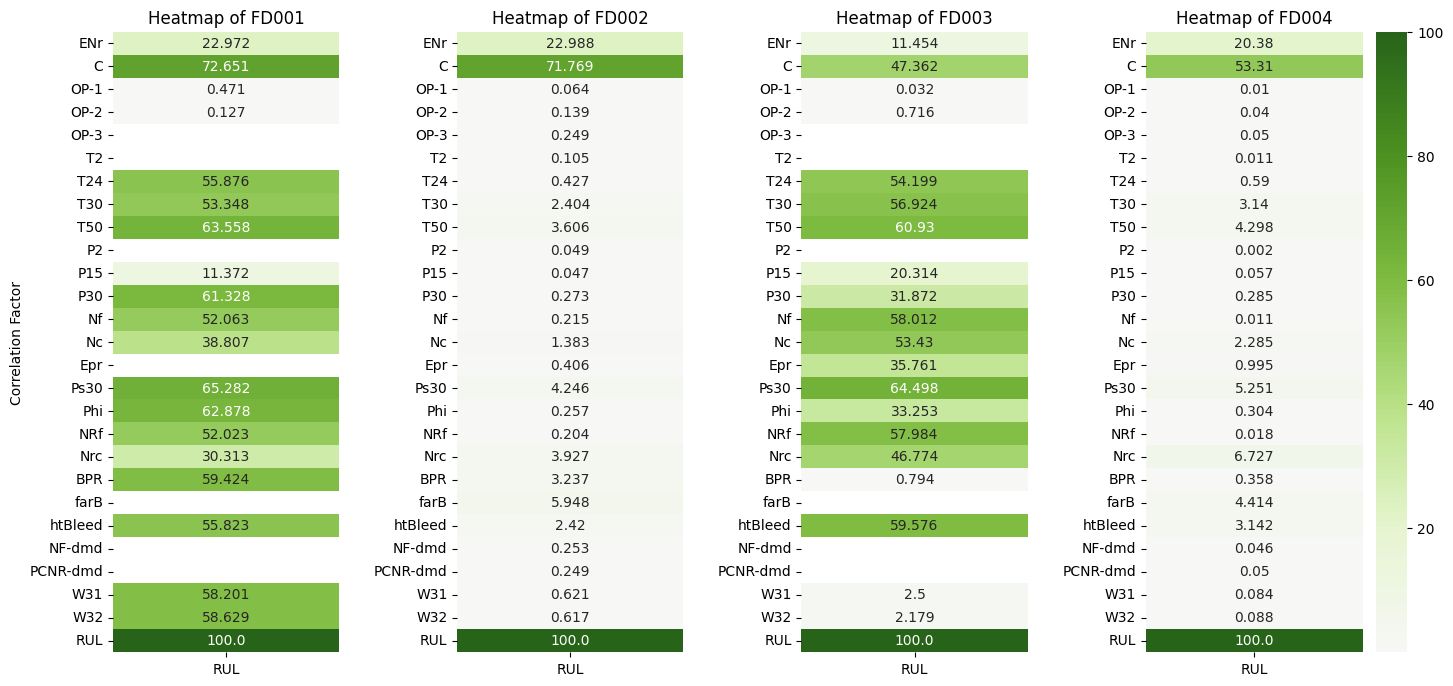

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})

sns.heatmap(p1.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[0], cbar=False)
axs[0].set_title('Heatmap of FD001')
axs[0].set_ylabel('Correlation Factor')

sns.heatmap(p2.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[1], cbar=False)
axs[1].set_title('Heatmap of FD002')

sns.heatmap(p3.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[2], cbar=False)
axs[2].set_title('Heatmap of FD003')

sns.heatmap(p4.to_frame(), annot=True, center=0, cmap='PiYG', fmt='', ax=axs[3])
axs[3].set_title('Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95], pad=2.5)

plt.show()

In [ ]:
def all_correlations(turbofan):
  correlation_matrix = turbofan.corr(method='pearson')
  return round(correlation_matrix, 2)

In [ ]:
pear1=all_correlations(turbofan1)
pear2=all_correlations(turbofan2)
pear3=all_correlations(turbofan3)
pear4=all_correlations(turbofan4)

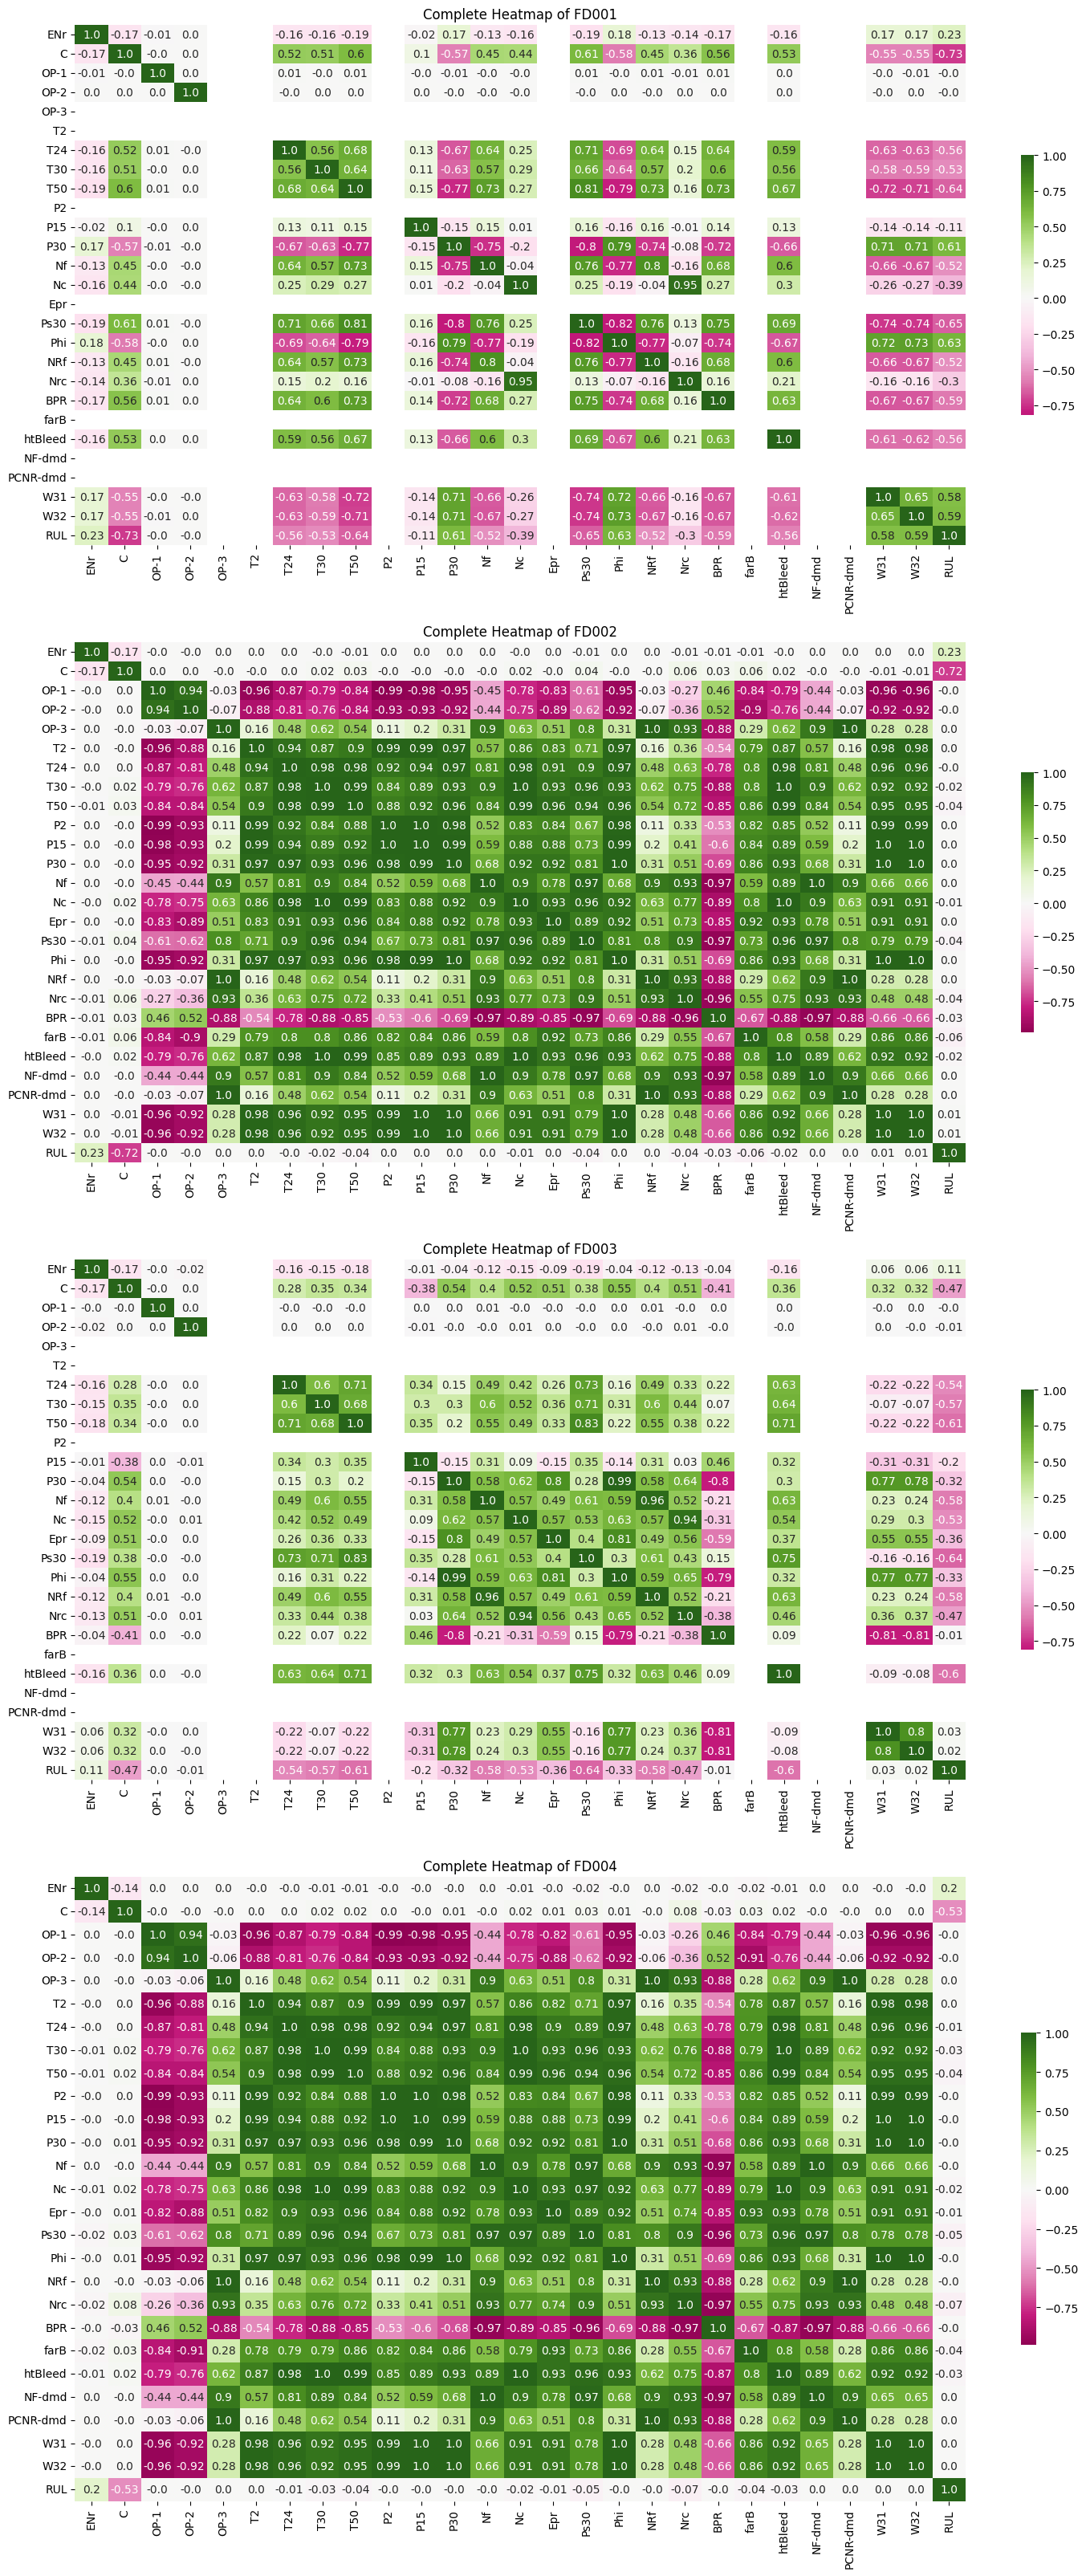

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(15, 35), gridspec_kw={'height_ratios': [1, 1, 1, 1.2]})

sns.heatmap(pear1, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[0], cbar_kws={"shrink": .5})
axs[0].set_title('Complete Heatmap of FD001')

sns.heatmap(pear2, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[1], cbar_kws={"shrink": .5})
axs[1].set_title('Complete Heatmap of FD002')

sns.heatmap(pear3, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[2], cbar_kws={"shrink": .5})
axs[2].set_title('Complete Heatmap of FD003')

sns.heatmap(pear4, annot=True, center=0, cmap='PiYG', fmt='', ax=axs[3], cbar_kws={"shrink": .5})
axs[3].set_title('Complete Heatmap of FD004')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [ ]:
sensor_pairs = []
for i, pear in enumerate([pear1, pear2, pear3, pear4], start=1):
    for sensor1, row in pear.iterrows():
        for sensor2, correlation in row.items():
            if correlation == 1 and sensor1 != sensor2:
                sensor_pairs.append((f'FD00{i}_{sensor1}', f'FD00{i}_{sensor2}'))

sensor_pairs_list= pd.DataFrame(sensor_pairs, columns=['Sensor1', 'Sensor2'])

In [ ]:
sensor_pairs_list

,Sensor1,Sensor2
0,FD002_OP-3,FD002_NRf
1,FD002_OP-3,FD002_PCNR-dmd
2,FD002_T30,FD002_Nc
3,FD002_T30,FD002_htBleed
4,FD002_P2,FD002_P15
...,...,...
59,FD004_W31,FD004_W32
60,FD004_W32,FD004_P15
61,FD004_W32,FD004_P30
62,FD004_W32,FD004_Phi


##Exclusions from each dataset based on correlation:
###Subset 1: (excluding all sensors correlated under 30%)
 OP-1, OP-2, OP-3, T2, P2, P15, Epr, farB, NF-dmd, PCNR-dmd

###Subset 2: (correlated 100% with other sensors)
OP-3, P2, Nc, Phi, htBleed, NF-dmd, PCNR-dmd, W31, W32

###Subset 3:(excluding all sensors correlated under 30%)
OP-1, OP-2, OP-3, T2, P2, P15, BPR, farB, NF-dmd, PCNR-dmd, W31, W32

###Subset 4:(correlated 100% with other sensors)
OP-3, P2, Nc, Phi, htBleed, NF-dmd, PCNR-dmd, W31, W32


In [ ]:
columns_to_drop1 = ['OP-1', 'OP-2', 'OP-3', 'T2', 'P2', 'P15', 'Epr', 'farB', 'NF-dmd', 'PCNR-dmd']
columns_to_drop24 = ['OP-3', 'P2', 'Nc', 'Phi', 'htBleed', 'NF-dmd', 'PCNR-dmd', 'W31', 'W32']
columns_to_drop3 = ['OP-1', 'OP-2', 'OP-3', 'T2', 'P2', 'P15', 'BPR', 'farB', 'NF-dmd', 'PCNR-dmd', 'W31', 'W32']

In [ ]:
turbofan1.drop(columns=columns_to_drop1, inplace=True)
turbofan2.drop(columns=columns_to_drop24, inplace=True)
turbofan3.drop(columns=columns_to_drop3, inplace=True)
turbofan4.drop(columns=columns_to_drop24, inplace=True)

In [ ]:
turbofan3

,ENr,C,T24,T30,T50,P30,Nf,Nc,Epr,Ps30,Phi,NRf,Nrc,htBleed,RUL
0,1,1,642.36,1583.23,1396.84,553.97,2387.96,9062.17,1.30,47.30,522.31,2388.01,8145.32,391,258
1,1,2,642.50,1584.69,1396.89,554.55,2388.00,9061.78,1.30,47.23,522.42,2388.03,8152.85,392,257
2,1,3,642.18,1582.35,1405.61,554.43,2388.03,9070.23,1.30,47.22,522.03,2388.00,8150.17,391,256
3,1,4,642.92,1585.61,1392.27,555.21,2388.00,9064.57,1.30,47.24,522.49,2388.08,8146.56,392,255
4,1,5,641.68,1588.63,1397.65,554.74,2388.04,9076.14,1.30,47.15,522.58,2388.03,8147.80,392,254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41311,200,243,643.04,1594.99,1411.28,561.21,2388.24,9088.31,1.31,47.61,529.23,2388.24,8162.24,395,32
41312,200,244,642.47,1591.27,1417.64,561.02,2388.29,9085.35,1.31,47.75,529.27,2388.26,8163.24,394,31
41313,200,245,642.70,1593.81,1412.70,561.16,2388.23,9084.29,1.31,47.60,529.48,2388.28,8162.12,394,30
41314,200,246,642.19,1595.63,1406.58,562.66,2388.24,9092.52,1.31,47.69,529.39,2388.33,8164.20,395,29


#Preprocessing

##Filtering

In [ ]:
def moving_median(turbofan, window_size, period):
    columns_to_filter = turbofan.columns.drop(['ENr', 'C', 'RUL'])
    filtered_turbo = turbofan.copy()
    filtered_turbo[columns_to_filter] = turbofan[columns_to_filter].rolling(window=window_size, min_periods=period, axis=0).median()
    return filtered_turbo

In [ ]:
filtered_turbo1=moving_median(turbofan1, 12, 1)
filtered_turbo2=moving_median(turbofan2, 12, 1)
filtered_turbo3=moving_median(turbofan3, 12, 1)
filtered_turbo4=moving_median(turbofan4, 12, 1)

In [ ]:
filtered_turbo1

,ENr,C,T24,T30,T50,P30,Nf,Nc,Ps30,Phi,NRf,Nrc,BPR,htBleed,W31,W32,RUL
0,1,1,641.820,1589.700,1400.600,554.360,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.41950,392.0,39.060,23.41900,191
1,1,2,641.985,1590.760,1401.870,554.055,2388.050,9045.130,47.480,521.970,2388.045,8135.055,8.42565,392.0,39.030,23.42130,190
2,1,3,642.150,1589.700,1403.140,554.260,2388.060,9046.190,47.470,522.280,2388.030,8133.230,8.41950,392.0,39.000,23.41900,189
3,1,4,642.250,1588.845,1402.505,554.310,2388.070,9047.835,47.370,522.350,2388.050,8133.530,8.41865,392.0,38.975,23.39645,188
4,1,5,642.350,1587.990,1403.140,554.260,2388.060,9049.480,47.280,522.280,2388.040,8133.800,8.41950,392.0,38.950,23.40440,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,643.000,1595.265,1415.980,553.220,2388.040,9133.520,47.595,521.515,2388.055,8204.640,8.45155,394.0,38.755,23.30500,24
33723,200,195,643.075,1595.395,1416.210,553.210,2388.050,9136.370,47.605,521.435,2388.060,8207.100,8.45400,394.0,38.755,23.29795,23
33724,200,196,643.160,1594.170,1416.020,553.200,2388.050,9136.950,47.590,521.300,2388.055,8208.895,8.45405,394.5,38.725,23.29795,22
33725,200,197,643.230,1595.090,1416.600,553.230,2388.055,9138.615,47.590,521.280,2388.065,8210.040,8.46005,395.0,38.685,23.28615,21


##Data Normalization

In [ ]:
def z_score(turbofan):
  scaler = StandardScaler()
  normalized_turbo = turbofan.copy()
  columns_to_normalize = turbofan.columns.drop(['ENr', 'C', 'RUL'])
  normalized_turbo[columns_to_normalize] = scaler.fit_transform(turbofan[columns_to_normalize])
  return normalized_turbo

In [ ]:
normalized_turbo1=z_score(turbofan1)
normalized_turbo2=z_score(turbofan2)
normalized_turbo3=z_score(turbofan3)
normalized_turbo4=z_score(turbofan4)

In [ ]:
normalized_turbo1

,ENr,C,T24,T30,T50,P30,Nf,Nc,Ps30,Phi,NRf,Nrc,BPR,htBleed,W31,W32,RUL
0,1,1,-1.644975,0.020217,-0.794964,1.008357,-0.396802,-0.864091,-0.090766,0.168348,-0.981906,-0.199424,-0.461431,-0.655669,1.254019,1.091572,191
1,1,2,-0.949920,0.383216,-0.493750,0.276905,-0.694283,-0.975799,-0.010603,1.062424,-0.242468,-0.634651,-0.113571,-0.655669,0.902637,1.136638,190
2,1,3,-0.528674,-0.272579,-0.368046,0.888447,-0.099321,-0.508416,-0.892393,1.264312,-0.834018,-0.528438,-0.509509,-2.018065,0.609819,0.358754,189
3,1,4,-0.528674,-1.162954,-0.644357,1.116276,0.346901,-0.690733,-1.453533,1.898818,-0.094581,-0.491813,-1.912263,-0.655669,0.199874,0.649726,188
4,1,5,-0.486549,-1.152680,-0.128498,0.576681,-0.396802,-0.391966,-0.852312,0.932638,-0.686131,-0.493645,-0.181446,0.025530,0.317001,0.948535,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33722,200,194,1.345871,1.689670,1.006393,-0.130789,-0.991764,4.203881,0.791025,-1.230449,-1.277681,4.357951,1.009197,0.706728,-1.147090,-1.079451,24
33723,200,195,1.303746,1.045861,1.748756,-0.358619,-0.545543,4.114831,0.430292,-0.711308,0.053306,4.209620,0.435087,1.387926,-1.615598,-0.298627,23
33724,200,196,1.767116,0.610947,-0.057345,-0.574457,0.346901,4.437836,0.310048,-0.523840,-0.686131,4.599676,0.596290,1.387926,-1.322780,-1.004014,22
33725,200,197,1.387995,0.926002,1.429753,-0.178753,-0.248061,4.545329,0.470374,-0.307532,-0.094581,4.797451,0.997885,1.387926,-1.088526,-0.369166,21


##Degradation modeling

In [ ]:
#for one engine
engine_sensors = normalized_turbo1[normalized_turbo1['ENr'] == 56]
eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
engine_values=eng_sens.values

N = len(engine_sensors)
window_length = 12
Th=0.001
g=N/window_length
centroids=[]
mean_centroids=[]
sq=[]
iruls=[]


windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

for window in windows:
  centroid=window.mean()
  centroids.append(centroid)
  mean_centroid=centroid.mean()
  mean_centroids.append(mean_centroid)

for i in range(len(windows)-1):
  s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
  squared=s**2
  sq.append(squared)
  if squared>=Th:
    irul=N-window_length*i
    iruls.append(irul)
  else:
    i=i+1

print(max(iruls))

251


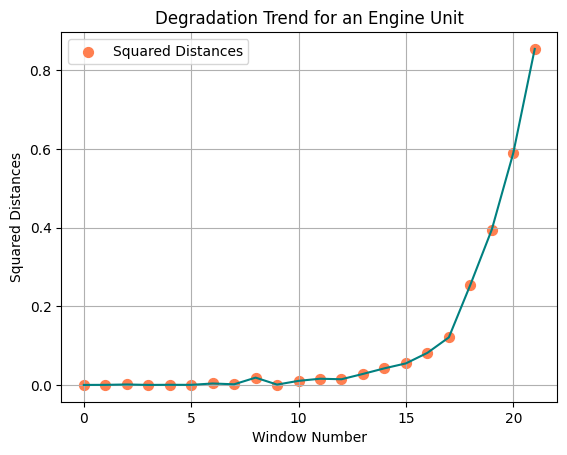

In [ ]:
plt.scatter(range(len(sq)), sq, color='coral', label='Squared Distances', s=50)
plt.xlabel('Window Number')
plt.ylabel('Squared Distances')
plt.title('Degradation Trend for an Engine Unit')
plt.legend()
plt.grid(True)


plt.plot(range(len(sq)), sq, color='teal', linestyle='-')

In [ ]:
def degradation_model(normalized_turbo, nr_eng, window_length, Th):
  RULs=[]
  RUL=0
  for i in range (1, nr_eng):
    engine_sensors = normalized_turbo[normalized_turbo['ENr'] == i]
    eng_sens = engine_sensors.drop(columns=['ENr', 'C', 'RUL'])
    engine_values=eng_sens.values

    N = len(engine_sensors)
    g=N/window_length
    centroids=[]
    mean_centroids=[]
    sq=[]
    iruls=[]


    windows = [engine_values[i:i+window_length] for i in range(0, len(engine_values), window_length)]

    for window in windows:
      centroid=window.mean()
      centroids.append(centroid)
      mean_centroid=centroid.mean()
      mean_centroids.append(mean_centroid)

    for i in range(len(windows)-1):
      s=np.sqrt(np.sum((mean_centroids[i] - mean_centroids[0])**2))
      squared=s**2
      sq.append(squared)
      if squared>=Th:
        irul=N-window_length*i
        iruls.append(irul)
      else:
        i=i+1

    RUL=max(iruls)
    RULs.append(RUL)
  final_RUL=min(RULs)
  return final_RUL


In [ ]:
initial_RUL1=degradation_model(normalized_turbo1, nr_train_1, 12, 0.01)
initial_RUL2=degradation_model(normalized_turbo2, nr_train_2, 12, 0.01)
initial_RUL3=degradation_model(normalized_turbo3, nr_train_3, 12, 0.01)
initial_RUL4=degradation_model(normalized_turbo4, nr_train_4, 12, 0.01)

In [ ]:
print("Minimum initial (w=5, th=0.01) RUL for FD001:", initial_RUL1)
print("Minimum initial (w=5, th=0.01) RUL for FD002:", initial_RUL2)
print("Minimum initial (w=5, th=0.01) RUL for FD003:", initial_RUL3)
print("Minimum initial (w=5, th=0.01) RUL for FD001:", initial_RUL4)

Minimum initial (w=5, th=0.01) RUL for FD001: 63
Minimum initial (w=5, th=0.01) RUL for FD002: 80
Minimum initial (w=5, th=0.01) RUL for FD003: 73
Minimum initial (w=5, th=0.01) RUL for FD001: 80


#Assigning RUL labels

In [ ]:
def split_dataframe(normalized_turbofan, nr_train):
  turbo_RUL_train = normalized_turbofan[(normalized_turbofan['ENr'] <= nr_train)]
  turbo_RUL_test = normalized_turbofan[(normalized_turbofan['ENr'] > nr_train)]
  return turbo_RUL_train, turbo_RUL_test

In [ ]:
turbo1_RUL_train, turbo1_RUL_test=split_dataframe(normalized_turbo1, nr_train_1)
turbo2_RUL_train, turbo2_RUL_test=split_dataframe(normalized_turbo2, nr_train_2)
turbo3_RUL_train, turbo3_RUL_test=split_dataframe(normalized_turbo3, nr_train_3)
turbo4_RUL_train, turbo4_RUL_test=split_dataframe(normalized_turbo4, nr_train_4)

In [ ]:
turbo2_RUL_test

,ENr,C,OP-1,OP-2,T2,T24,T30,T50,P15,P30,Nf,Epr,Ps30,NRf,Nrc,BPR,farB,RUL
53759,261,1,-0.947915,-1.035804,0.610727,0.680517,0.733717,0.843531,0.714500,0.764417,0.620027,1.292509,0.821478,0.418515,0.575995,-0.903523,1.439723,275
53760,261,2,-0.270119,0.413325,0.691743,0.755300,0.583000,0.349136,0.377954,0.352763,0.654400,-0.118605,0.403607,0.418046,-0.146715,-0.111609,-0.694578,274
53761,261,3,0.746308,0.864365,-0.888823,-0.633672,-0.569509,-0.639570,-0.662949,-0.610431,-0.043238,-0.588977,-0.357847,0.415156,-0.146952,0.030907,-0.694578,273
53762,261,4,1.220722,0.867587,-1.056912,-0.789938,-0.658128,-0.643516,-1.084092,-0.985352,-0.119628,-0.588977,-0.230938,0.414921,0.017150,0.096221,-0.694578,272
53763,261,5,0.068369,0.159775,-0.392885,-1.150448,-1.568942,-1.291738,-0.473527,-0.732189,-2.161845,-1.216139,-1.917898,-2.395062,-2.365519,2.062450,-0.694578,271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87745,519,119,0.746104,0.865332,-0.888823,-0.645465,-0.504107,-0.630249,-0.662949,-0.601401,-0.039312,-0.588977,-0.308321,0.420156,0.271235,-0.003420,-0.694578,55
87746,519,120,1.220722,0.865976,-1.056912,-0.810040,-0.644538,-0.677355,-1.082253,-0.988088,-0.115427,-0.588977,-0.295940,0.419531,0.509454,0.040256,-0.694578,54
87747,519,121,1.220688,0.864365,-1.056912,-0.803876,-0.663318,-0.718918,-1.082253,-0.988567,-0.114738,-0.588977,-0.249510,0.419765,0.394489,0.079525,-0.694578,53
87748,519,122,-1.625196,-1.840911,1.732077,1.686999,1.606121,1.709814,1.840000,1.849233,1.095934,1.606090,1.397212,0.417109,1.141352,-1.196968,1.439723,52


In [ ]:
def RUL_train(turbo_RUL_train, initial_RUL):
  turbo_RUL_train['RUL'] = turbo_RUL_train.groupby('ENr')['C'].transform(lambda x: x.max())-initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['C'] >initial_RUL, 'RUL'] -= turbo_RUL_train['C'] - initial_RUL
  turbo_RUL_train.loc[turbo_RUL_train['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_train

In [ ]:
turbo1_RUL_train=RUL_train(turbo1_RUL_train, initial_RUL1)
turbo2_RUL_train=RUL_train(turbo2_RUL_train, initial_RUL2)
turbo3_RUL_train=RUL_train(turbo3_RUL_train, initial_RUL3)
turbo4_RUL_train=RUL_train(turbo4_RUL_train, initial_RUL4)

In [ ]:
turbo4_RUL_train

,ENr,C,OP-1,OP-2,T2,T24,T30,T50,P15,P30,Nf,Epr,Ps30,NRf,Nrc,BPR,farB,RUL
0,1,1,1.217199,0.862329,-1.053935,-0.794450,-0.692139,-0.732875,-1.081197,-0.992861,-0.115637,-0.672486,-0.349453,0.417339,0.104258,0.064543,-0.680107,241
1,1,2,-0.274109,0.411315,0.696325,0.719084,0.575173,0.314830,0.375364,0.336802,0.654856,-0.201440,0.346681,0.415309,-0.233064,-0.125578,-0.680107,241
2,1,3,1.217125,0.865233,-1.053935,-0.814044,-0.695067,-0.698223,-1.083038,-0.987262,-0.115223,-0.672486,-0.358735,0.417183,0.007763,0.154389,-0.680107,241
3,1,4,1.216867,0.862329,-1.053935,-0.820754,-0.712823,-0.689981,-1.081197,-0.988627,-0.115499,-0.593978,-0.352547,0.417573,0.118597,0.069089,-0.680107,241
4,1,5,0.065071,0.154837,-0.389298,-1.158944,-1.525177,-1.400169,-0.473529,-0.737088,-2.159992,-1.300547,-1.961390,-2.393404,-2.352546,2.074184,-0.680107,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,-0.952037,-1.041093,0.615235,0.699222,0.941162,0.969003,0.716026,0.831755,0.627289,1.368714,1.008782,0.423118,1.407235,-1.111213,1.470357,4
61245,249,252,-1.629611,-1.842788,1.737615,1.721576,1.720931,1.906697,1.841132,1.944701,1.101508,1.682744,1.615192,0.421010,1.404649,-1.421396,1.470357,3
61246,249,253,-1.629605,-1.847628,1.737615,1.728555,1.804045,1.938574,1.841132,1.954601,1.101783,1.682744,1.677071,0.421166,1.504200,-1.380752,1.470357,2
61247,249,254,0.742734,0.862329,-0.885692,-0.630992,-0.334556,-0.436402,-0.665037,-0.565640,-0.033487,-0.358455,-0.089563,0.423899,0.701446,-0.312491,-0.680107,1


In [ ]:
def RUL_test(turbo_RUL_test, initial_RUL, nr_train, y_RUL):
  y_RUL_series = y_RUL[0]
  adjusted_engine_numbers = turbo_RUL_test['ENr'].values - nr_train-1
  turbo_RUL_test['RUL'] = turbo_RUL_test.groupby('ENr')['C'].transform(lambda x: x.max()) + y_RUL_series.iloc[adjusted_engine_numbers].values -initial_RUL
  turbo_RUL_test.loc[turbo_RUL_test['C'] > initial_RUL, 'RUL'] -= turbo_RUL_test['C'] - initial_RUL
  turbo_RUL_test.loc[turbo_RUL_test['RUL'] < 0, 'RUL'] = 0
  return turbo_RUL_test

In [ ]:
turbo1_RUL_test=RUL_test(turbo1_RUL_test, initial_RUL1, nr_train_1, y_RUL_1)
turbo2_RUL_test=RUL_test(turbo2_RUL_test, initial_RUL2, nr_train_2, y_RUL_2)
turbo3_RUL_test=RUL_test(turbo3_RUL_test, initial_RUL3, nr_train_3, y_RUL_3)
turbo4_RUL_test=RUL_test(turbo4_RUL_test, initial_RUL4, nr_train_4, y_RUL_4)

In [ ]:
turbo4_RUL_test

,ENr,C,OP-1,OP-2,T2,T24,T30,T50,P15,P30,Nf,Epr,Ps30,NRf,Nrc,BPR,farB,RUL
61249,250,1,-0.273757,0.410670,0.696325,0.735189,0.607569,0.233331,0.373523,0.339670,0.654925,-0.201440,0.312648,0.415699,-0.199566,-0.083329,-0.680107,172
61250,250,2,0.064536,0.152579,-0.389298,-1.155723,-1.516298,-1.417915,-0.473529,-0.739546,-2.160061,-1.300547,-2.075865,-2.393326,-2.380049,2.109748,-0.680107,172
61251,250,3,1.216867,0.868782,-1.053935,-0.806528,-0.723307,-0.792169,-1.083038,-0.992997,-0.115154,-0.672486,-0.402050,0.417027,0.060770,0.148105,-0.680107,172
61252,250,4,1.217104,0.862975,-1.053935,-0.807602,-0.727368,-0.780563,-1.083038,-0.993748,-0.115430,-0.672486,-0.337077,0.416636,0.151976,0.099171,-0.680107,172
61253,250,5,0.742958,0.862329,-0.885692,-0.648975,-0.601374,-0.691915,-0.663195,-0.613367,-0.040862,-0.593978,-0.463928,0.416402,-0.095549,0.023764,-0.680107,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102458,497,277,1.216806,0.862652,-1.053935,-0.777809,-0.494080,-0.596287,-1.077514,-0.986169,-0.112260,-0.593978,-0.160723,0.421322,0.548300,0.210543,-0.680107,30
102459,497,278,-0.274069,0.412283,0.696325,0.770887,0.737058,0.511469,0.384571,0.354896,0.658784,-0.201440,0.529223,0.419994,0.245298,-0.010730,-0.680107,29
102460,497,279,0.742341,0.866523,-0.885692,-0.626966,-0.435050,-0.581148,-0.657671,-0.599847,-0.034935,-0.593978,-0.151441,0.422415,0.409963,0.151046,-0.680107,28
102461,497,280,-0.274062,0.410670,0.696325,0.775986,0.683789,0.472528,0.384571,0.343971,0.658509,-0.201440,0.606571,0.420307,0.226610,-0.016747,1.470357,27


In [ ]:
def concatenate(turbo_RUL_train, turbo_RUL_test):
  tr = pd.concat([turbo_RUL_train, turbo_RUL_test], axis=0)
  return tr

In [ ]:
tr1=concatenate(turbo1_RUL_train, turbo1_RUL_test)
tr2=concatenate(turbo2_RUL_train, turbo2_RUL_test)
tr3=concatenate(turbo3_RUL_train, turbo3_RUL_test)
tr4=concatenate(turbo4_RUL_train, turbo4_RUL_test)

In [ ]:
tr4

,ENr,C,OP-1,OP-2,T2,T24,T30,T50,P15,P30,Nf,Epr,Ps30,NRf,Nrc,BPR,farB,RUL
0,1,1,1.217199,0.862329,-1.053935,-0.794450,-0.692139,-0.732875,-1.081197,-0.992861,-0.115637,-0.672486,-0.349453,0.417339,0.104258,0.064543,-0.680107,241
1,1,2,-0.274109,0.411315,0.696325,0.719084,0.575173,0.314830,0.375364,0.336802,0.654856,-0.201440,0.346681,0.415309,-0.233064,-0.125578,-0.680107,241
2,1,3,1.217125,0.865233,-1.053935,-0.814044,-0.695067,-0.698223,-1.083038,-0.987262,-0.115223,-0.672486,-0.358735,0.417183,0.007763,0.154389,-0.680107,241
3,1,4,1.216867,0.862329,-1.053935,-0.820754,-0.712823,-0.689981,-1.081197,-0.988627,-0.115499,-0.593978,-0.352547,0.417573,0.118597,0.069089,-0.680107,241
4,1,5,0.065071,0.154837,-0.389298,-1.158944,-1.525177,-1.400169,-0.473529,-0.737088,-2.159992,-1.300547,-1.961390,-2.393404,-2.352546,2.074184,-0.680107,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102458,497,277,1.216806,0.862652,-1.053935,-0.777809,-0.494080,-0.596287,-1.077514,-0.986169,-0.112260,-0.593978,-0.160723,0.421322,0.548300,0.210543,-0.680107,30
102459,497,278,-0.274069,0.412283,0.696325,0.770887,0.737058,0.511469,0.384571,0.354896,0.658784,-0.201440,0.529223,0.419994,0.245298,-0.010730,-0.680107,29
102460,497,279,0.742341,0.866523,-0.885692,-0.626966,-0.435050,-0.581148,-0.657671,-0.599847,-0.034935,-0.593978,-0.151441,0.422415,0.409963,0.151046,-0.680107,28
102461,497,280,-0.274062,0.410670,0.696325,0.775986,0.683789,0.472528,0.384571,0.343971,0.658509,-0.201440,0.606571,0.420307,0.226610,-0.016747,1.470357,27


##Preparing for training

In [ ]:
train1, test1=split_dataframe(tr1, nr_train_1)
train2, test2=split_dataframe(tr2, nr_train_2)
train3, test3=split_dataframe(tr3, nr_train_3)
train4, test4=split_dataframe(tr4, nr_train_4)

In [ ]:
test4

,ENr,C,OP-1,OP-2,T2,T24,T30,T50,P15,P30,Nf,Epr,Ps30,NRf,Nrc,BPR,farB,RUL
61249,250,1,-0.273757,0.410670,0.696325,0.735189,0.607569,0.233331,0.373523,0.339670,0.654925,-0.201440,0.312648,0.415699,-0.199566,-0.083329,-0.680107,172
61250,250,2,0.064536,0.152579,-0.389298,-1.155723,-1.516298,-1.417915,-0.473529,-0.739546,-2.160061,-1.300547,-2.075865,-2.393326,-2.380049,2.109748,-0.680107,172
61251,250,3,1.216867,0.868782,-1.053935,-0.806528,-0.723307,-0.792169,-1.083038,-0.992997,-0.115154,-0.672486,-0.402050,0.417027,0.060770,0.148105,-0.680107,172
61252,250,4,1.217104,0.862975,-1.053935,-0.807602,-0.727368,-0.780563,-1.083038,-0.993748,-0.115430,-0.672486,-0.337077,0.416636,0.151976,0.099171,-0.680107,172
61253,250,5,0.742958,0.862329,-0.885692,-0.648975,-0.601374,-0.691915,-0.663195,-0.613367,-0.040862,-0.593978,-0.463928,0.416402,-0.095549,0.023764,-0.680107,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102458,497,277,1.216806,0.862652,-1.053935,-0.777809,-0.494080,-0.596287,-1.077514,-0.986169,-0.112260,-0.593978,-0.160723,0.421322,0.548300,0.210543,-0.680107,30
102459,497,278,-0.274069,0.412283,0.696325,0.770887,0.737058,0.511469,0.384571,0.354896,0.658784,-0.201440,0.529223,0.419994,0.245298,-0.010730,-0.680107,29
102460,497,279,0.742341,0.866523,-0.885692,-0.626966,-0.435050,-0.581148,-0.657671,-0.599847,-0.034935,-0.593978,-0.151441,0.422415,0.409963,0.151046,-0.680107,28
102461,497,280,-0.274062,0.410670,0.696325,0.775986,0.683789,0.472528,0.384571,0.343971,0.658509,-0.201440,0.606571,0.420307,0.226610,-0.016747,1.470357,27


In [ ]:
def split_train(tr):
  X=tr.iloc[:, :-1]
  y=tr.iloc[:, -1]
  return X, y

In [ ]:
X1_train, y1_train=split_train(train1)
X1_test, y1_test=split_train(test1)

X2_train, y2_train=split_train(train2)
X2_test, y2_test=split_train(test2)

X3_train, y3_train=split_train(train3)
X3_test, y3_test=split_train(test3)

X4_train, y4_train=split_train(train4)
X4_test, y4_test=split_train(test4)


In [ ]:
X4_test

,ENr,C,OP-1,OP-2,T2,T24,T30,T50,P15,P30,Nf,Epr,Ps30,NRf,Nrc,BPR,farB
61249,250,1,-0.273757,0.410670,0.696325,0.735189,0.607569,0.233331,0.373523,0.339670,0.654925,-0.201440,0.312648,0.415699,-0.199566,-0.083329,-0.680107
61250,250,2,0.064536,0.152579,-0.389298,-1.155723,-1.516298,-1.417915,-0.473529,-0.739546,-2.160061,-1.300547,-2.075865,-2.393326,-2.380049,2.109748,-0.680107
61251,250,3,1.216867,0.868782,-1.053935,-0.806528,-0.723307,-0.792169,-1.083038,-0.992997,-0.115154,-0.672486,-0.402050,0.417027,0.060770,0.148105,-0.680107
61252,250,4,1.217104,0.862975,-1.053935,-0.807602,-0.727368,-0.780563,-1.083038,-0.993748,-0.115430,-0.672486,-0.337077,0.416636,0.151976,0.099171,-0.680107
61253,250,5,0.742958,0.862329,-0.885692,-0.648975,-0.601374,-0.691915,-0.663195,-0.613367,-0.040862,-0.593978,-0.463928,0.416402,-0.095549,0.023764,-0.680107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102458,497,277,1.216806,0.862652,-1.053935,-0.777809,-0.494080,-0.596287,-1.077514,-0.986169,-0.112260,-0.593978,-0.160723,0.421322,0.548300,0.210543,-0.680107
102459,497,278,-0.274069,0.412283,0.696325,0.770887,0.737058,0.511469,0.384571,0.354896,0.658784,-0.201440,0.529223,0.419994,0.245298,-0.010730,-0.680107
102460,497,279,0.742341,0.866523,-0.885692,-0.626966,-0.435050,-0.581148,-0.657671,-0.599847,-0.034935,-0.593978,-0.151441,0.422415,0.409963,0.151046,-0.680107
102461,497,280,-0.274062,0.410670,0.696325,0.775986,0.683789,0.472528,0.384571,0.343971,0.658509,-0.201440,0.606571,0.420307,0.226610,-0.016747,1.470357


#Implementing the performance measures

In [ ]:
#the asymmetric scoring function  - MASCHLER !!!
def PHME_score(y_true, y_pred):
    dif=y_pred-y_true
    if dif>=0:
      score= math.exp(dif /10)-1
    else:
      score= math.exp(-dif /13)-1
    return score

In [ ]:
print("Score for an overestimation: ", PHME_score(112, 192))
print("Score for an underestimation: ", PHME_score(192, 112))

Score for an overestimation:  2979.9579870417283
Score for an underestimation:  469.5236172558757


In [ ]:
def RMSE(y_true, y_pred):
  return np.sqrt(np.mean((y_true - y_pred)**2))

In [ ]:
print("RMSE for an overestimation: ", RMSE(112, 192))
print("RMSE for an underestimation: ", RMSE(192, 112))

RMSE for an overestimation:  80.0
RMSE for an underestimation:  80.0


In [ ]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print("MAPE for an overestimation: ", MAPE(112, 192))
print("MAPE for an underestimation: ", MAPE(192, 112))

MAPE for an overestimation:  71.42857142857143
MAPE for an underestimation:  41.66666666666667


In [ ]:
def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
print("MAE for an overestimation: ", MAE(112, 192))
print("MAE for an underestimation: ", MAE(192, 112))

MAE for an overestimation:  80.0
MAE for an underestimation:  80.0


#Neural Network Construction

In [ ]:
def RMSE(y_true, y_pred):
    squared_errors = tf.square(y_true - y_pred)
    individual_rmse = tf.sqrt(tf.reduce_mean(squared_errors, axis=-1))
    return tf.keras.backend.mean(individual_rmse)

def PHME_score(y_true, y_pred):
    dif = y_pred - y_true
    positive_score = tf.exp(dif / 10) - 1
    negative_score = tf.exp(-dif / 13) - 1
    individual_score = tf.where(dif >= 0, positive_score, negative_score)
    return tf.keras.backend.mean(individual_score)

def MAPE(y_true, y_pred):
    absolute_percentage_errors = tf.abs((y_true - y_pred) / y_true)
    individual_mape = tf.reduce_mean(absolute_percentage_errors, axis=-1) * 100
    return tf.keras.backend.mean(individual_mape)

def MAE(y_true, y_pred):
    absolute_errors = tf.abs(y_true - y_pred)
    individual_mae = tf.reduce_mean(absolute_errors, axis=-1)
    return tf.keras.backend.mean(individual_mae)

##LSTM 20 epoch

In [ ]:
model = Sequential([
    LSTM(units=60, input_shape=(X1_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    LSTM(units=60, return_sequences=True),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAPE, MAE])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 16, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16, 60)            29040     
                                                                 
 dropout_1 (Dropout)         (None, 16, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16, 60)            29040     
                                                                 
 dropout_2 (Dropout)         (None, 16, 60)            0         
                                                                 
 lstm_3 (LSTM)               (None, 16, 60)            2

In [ ]:
history = model.fit(X1_train, y1_train, batch_size=15, epochs=20, validation_data=(X1_test, y1_test))


Epoch 1/20
1376/1376 [==============================] - 28s 14ms/step - loss: 3819.5417 - RMSE: 50.8253 - PHME_score: 1052026.2500 - MAPE: inf - MAE: 49.4167 - val_loss: 2016.9320 - val_RMSE: 36.4705 - val_PHME_score: 2009.7689 - val_MAPE: 34.6242 - val_MAE: 34.5308
Epoch 2/20
1376/1376 [==============================] - 18s 13ms/step - loss: 1830.7985 - RMSE: 35.4121 - PHME_score: 5088.2188 - MAPE: inf - MAE: 31.4575 - val_loss: 2006.7089 - val_RMSE: 38.6893 - val_PHME_score: 959.7801 - val_MAPE: 36.8025 - val_MAE: 36.4511
Epoch 3/20
1376/1376 [==============================] - 18s 13ms/step - loss: 1727.5145 - RMSE: 34.3137 - PHME_score: 4223.3447 - MAPE: inf - MAE: 30.3788 - val_loss: 2009.4934 - val_RMSE: 38.9928 - val_PHME_score: 888.1417 - val_MAPE: 39.0086 - val_MAE: 37.0512
Epoch 4/20
1376/1376 [==============================] - 18s 13ms/step - loss: 1664.2963 - RMSE: 33.6823 - PHME_score: 3064.3049 - MAPE: inf - MAE: 29.7236 - val_loss: 1912.3792 - val_RMSE: 35.3591 - val_PHME

In [ ]:
scores = model.evaluate(X1_test, y1_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAPE: {}'.format(scores[3]))
print('\nMAE: {}'.format(scores[4]))

y_pred = model.predict(X1_test,verbose=1, batch_size=200)
y_true = y1_test


66/66 [==============================] - 0s 6ms/step - loss: 1878.5073 - RMSE: 36.5747 - PHME_score: 865.4864 - MAPE: 32.2771 - MAE: 33.9331

RMSE: 36.57468032836914

PHME: 865.4863891601562

MAPE: 32.27713394165039

MAE: 33.93313217163086
66/66 [==============================] - 2s 5ms/step


##GRU 20 epoch

In [ ]:
model2 = Sequential([
    GRU(units=60, input_shape=(X1_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    GRU(units=60, return_sequences=True),
    Dropout(0.1),
    GRU(units=60, return_sequences=True),
    Dropout(0.1),
    GRU(units=60, return_sequences=True),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dropout(0.1),
    Dense(units=60),
    Dense(units=1)
])

model2.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAPE, MAE])

model2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16, 60)            11340     
                                                                 
 dropout_6 (Dropout)         (None, 16, 60)            0         
                                                                 
 gru_1 (GRU)                 (None, 16, 60)            21960     
                                                                 
 dropout_7 (Dropout)         (None, 16, 60)            0         
                                                                 
 gru_2 (GRU)                 (None, 16, 60)            21960     
                                                                 
 dropout_8 (Dropout)         (None, 16, 60)            0         
                                                                 
 gru_3 (GRU)                 (None, 16, 60)           

In [ ]:
history2 = model2.fit(X1_train, y1_train, batch_size=15, epochs=20, validation_data=(X1_test, y1_test))

Epoch 1/20
1376/1376 [==============================] - 25s 13ms/step - loss: 3814.7695 - RMSE: 50.6724 - PHME_score: 260679.9375 - MAPE: inf - MAE: 49.6320 - val_loss: 2696.8250 - val_RMSE: 40.3262 - val_PHME_score: 3489.9153 - val_MAPE: 46.8462 - val_MAE: 40.3224
Epoch 2/20
1376/1376 [==============================] - 17s 12ms/step - loss: 3697.6577 - RMSE: 49.9228 - PHME_score: 38851.4180 - MAPE: inf - MAE: 49.0310 - val_loss: 3935.9954 - val_RMSE: 49.5590 - val_PHME_score: 21501.0781 - val_MAPE: 44.8771 - val_MAE: 49.5583
Epoch 3/20
1376/1376 [==============================] - 17s 12ms/step - loss: 3706.2839 - RMSE: 49.9515 - PHME_score: 40689.6875 - MAPE: inf - MAE: 49.1009 - val_loss: 3740.9607 - val_RMSE: 48.1248 - val_PHME_score: 17446.2891 - val_MAPE: 44.6428 - val_MAE: 48.1246
Epoch 4/20
1376/1376 [==============================] - 17s 12ms/step - loss: 3688.9629 - RMSE: 49.7836 - PHME_score: 37645.0078 - MAPE: inf - MAE: 48.9561 - val_loss: 3849.6252 - val_RMSE: 48.9247 - va

In [ ]:
scores = model2.evaluate(X1_test, y1_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAPE: {}'.format(scores[3]))
print('\nMAE: {}'.format(scores[4]))

y_pred = model2.predict(X1_test,verbose=1, batch_size=200)
y_true = y1_test

66/66 [==============================] - 3s 6ms/step - loss: 18558.8457 - RMSE: 126.0218 - PHME_score: 20658578.0000 - MAPE: 100.0072 - MAE: 126.0218

RMSE: 126.0218276977539

PHME: 20658578.0

MAPE: 100.00715637207031

MAE: 126.0218276977539
66/66 [==============================] - 1s 5ms/step


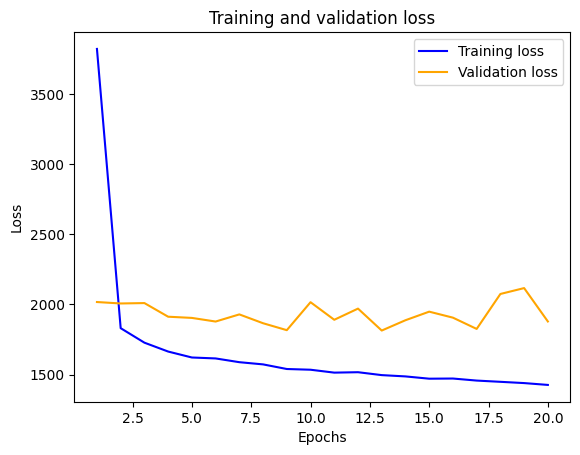

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##GRU less dense 30 epochs

In [ ]:
model3 = Sequential([
    GRU(units=60, input_shape=(X1_train.shape[1], 1), return_sequences=True),
    Dropout(0.1),
    GRU(units=60, return_sequences=True),
    Dropout(0.1),
    GRU(units=60, return_sequences=True),
    Dropout(0.1),
    GRU(units=60, return_sequences=True),
    Dropout(0.1),
    Dense(units=30),
    Dropout(0.1),
    Dense(units=30),
    Dropout(0.1),
    Dense(units=30),
    Dense(units=1)
])

model3.compile(optimizer='adam', loss='mean_squared_error',
              metrics=[RMSE, PHME_score, MAPE, MAE])

model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 16, 60)            11340     
                                                                 
 dropout_18 (Dropout)        (None, 16, 60)            0         
                                                                 
 gru_9 (GRU)                 (None, 16, 60)            21960     
                                                                 
 dropout_19 (Dropout)        (None, 16, 60)            0         
                                                                 
 gru_10 (GRU)                (None, 16, 60)            21960     
                                                                 
 dropout_20 (Dropout)        (None, 16, 60)            0         
                                                                 
 gru_11 (GRU)                (None, 16, 60)           

In [ ]:
history3 = model3.fit(X1_train, y1_train, batch_size=15, epochs=30, validation_data=(X1_test, y1_test))

Epoch 1/30
1376/1376 [==============================] - 25s 13ms/step - loss: 3796.2344 - RMSE: 50.8288 - PHME_score: 261696.1875 - MAPE: inf - MAE: 49.3888 - val_loss: 2653.1804 - val_RMSE: 42.1100 - val_PHME_score: 14466.0986 - val_MAPE: 35.2507 - val_MAE: 38.7815
Epoch 2/30
1376/1376 [==============================] - 17s 12ms/step - loss: 1949.8008 - RMSE: 37.3968 - PHME_score: 10717.6572 - MAPE: inf - MAE: 32.8761 - val_loss: 1938.8715 - val_RMSE: 37.6165 - val_PHME_score: 1306.5826 - val_MAPE: 33.2904 - val_MAE: 34.9382
Epoch 3/30
1376/1376 [==============================] - 17s 12ms/step - loss: 1745.9052 - RMSE: 34.9826 - PHME_score: 4541.6045 - MAPE: inf - MAE: 30.7097 - val_loss: 1892.9648 - val_RMSE: 36.9975 - val_PHME_score: 1001.8556 - val_MAPE: 34.2151 - val_MAE: 34.6469
Epoch 4/30
1376/1376 [==============================] - 17s 12ms/step - loss: 1676.5945 - RMSE: 34.2785 - PHME_score: 3656.3906 - MAPE: inf - MAE: 29.9940 - val_loss: 1845.1805 - val_RMSE: 35.6762 - val_P

In [ ]:
scores = model3.evaluate(X1_test, y1_test, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nPHME: {}'.format(scores[2]))
print('\nMAPE: {}'.format(scores[3]))
print('\nMAE: {}'.format(scores[4]))

y_pred = model3.predict(X1_test,verbose=1, batch_size=200)
y_true = y1_test

66/66 [==============================] - 0s 6ms/step - loss: 2054.2727 - RMSE: 38.3140 - PHME_score: 2088.5586 - MAPE: 32.3539 - MAE: 34.9186

RMSE: 38.31402587890625

PHME: 2088.55859375

MAPE: 32.353912353515625

MAE: 34.91860580444336
66/66 [==============================] - 1s 5ms/step


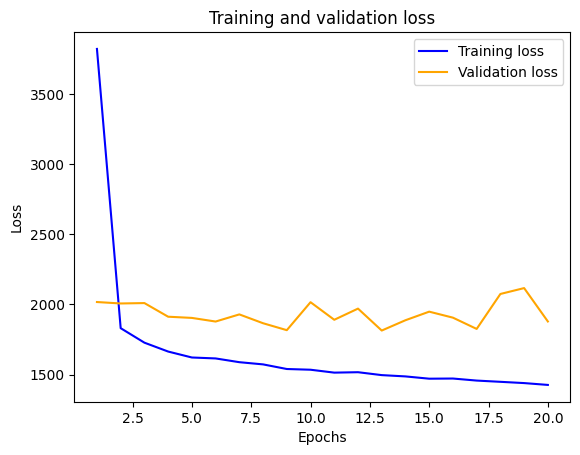

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##CNN-LSTM

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same' , input_shape=(X1_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.1))
model.add(Conv1D(32 , 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=1))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[RMSE, PHME_score, MAPE, MAE])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 16, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 16, 64)            0         
 g1D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 16, 64)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 16, 32)            6176      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 16, 32)            0         
 g1D)                                                            
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 32)           

In [ ]:
history5 = model.fit(X1_train, y1_train, batch_size=15, epochs=100, validation_data=(X1_test, y1_test))

Epoch 1/100
1376/1376 [==============================] - 17s 9ms/step - loss: 7094.4268 - RMSE: 66.7469 - PHME_score: 4078890.0000 - MAPE: inf - MAE: 66.7469 - val_loss: 5329.8159 - val_RMSE: 59.5809 - val_PHME_score: 70922.7031 - val_MAPE: 48.3897 - val_MAE: 59.5809
Epoch 2/100
1376/1376 [==============================] - 11s 8ms/step - loss: 2415.1248 - RMSE: 34.6173 - PHME_score: 43840.9336 - MAPE: inf - MAE: 34.6173 - val_loss: 2005.7546 - val_RMSE: 33.0572 - val_PHME_score: 2187.0168 - val_MAPE: 27.0567 - val_MAE: 33.0572
Epoch 3/100
1376/1376 [==============================] - 11s 8ms/step - loss: 1501.1958 - RMSE: 26.9940 - PHME_score: 2809.8779 - MAPE: inf - MAE: 26.9940 - val_loss: 1743.4489 - val_RMSE: 31.9596 - val_PHME_score: 841.1542 - val_MAPE: 28.8361 - val_MAE: 31.9596
Epoch 4/100
1376/1376 [==============================] - 11s 8ms/step - loss: 1406.0050 - RMSE: 26.3036 - PHME_score: 1461.9364 - MAPE: inf - MAE: 26.3036 - val_loss: 1720.1339 - val_RMSE: 31.8988 - val_P